* Name = Pranav Patil
* MIS  = 712570009

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 100
batch_size = 128
epochs = 10
lr = 0.0002
img_channels = 1

In [5]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MNIST(
    root="/kaggle/working",
    train=True,
    transform=transform,
    download=True
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 43.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            # Input: Z → (batch, 100, 1, 1)
            nn.ConvTranspose2d(latent_dim, 256, 7, 1, 0, bias=False), # output 7x7 image
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), # output 14x14 image
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, img_channels, 4, 2, 1, bias=False), #output 28x28 image
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

output = (input − 1) × stride − 2×padding + kernel
* channels = 100 => 256 => 128 => 1
* spatial size = 1x1 => 7x7 => 14x14 => 28x28

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img).view(-1, 1)


output = (input + 2P − K) / S + 1
* input - an image (real or generated)
* output - single value (real or fake)
* spatial size = 28x28 => 14x14 => 7x7 => 1x1
* channels = 1 or 3 => 128 => 256 => 1 (final decision channel - real/fake score)

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


Epoch [1/10] Batch [0/469] D Loss: 0.9498 G Loss: 3.9471
Epoch [1/10] Batch [300/469] D Loss: 0.4658 G Loss: 2.4132


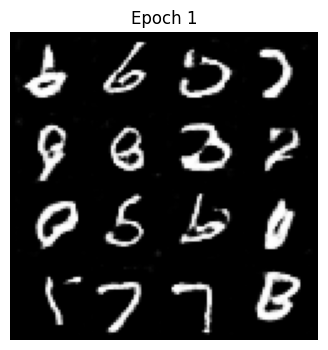

Epoch [2/10] Batch [0/469] D Loss: 0.5647 G Loss: 2.4459
Epoch [2/10] Batch [300/469] D Loss: 0.5998 G Loss: 1.7601


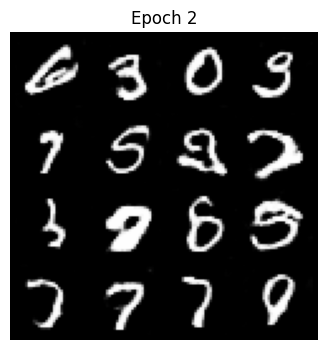

Epoch [3/10] Batch [0/469] D Loss: 0.6590 G Loss: 1.6013
Epoch [3/10] Batch [300/469] D Loss: 2.7384 G Loss: 0.1418


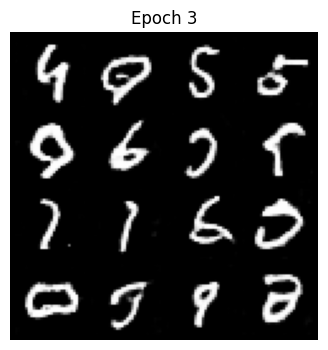

Epoch [4/10] Batch [0/469] D Loss: 0.5013 G Loss: 2.4278
Epoch [4/10] Batch [300/469] D Loss: 0.6675 G Loss: 2.1098


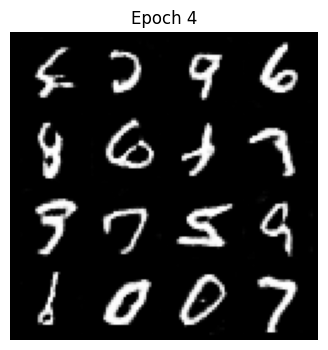

Epoch [5/10] Batch [0/469] D Loss: 0.7106 G Loss: 1.6908
Epoch [5/10] Batch [300/469] D Loss: 0.5886 G Loss: 2.1556


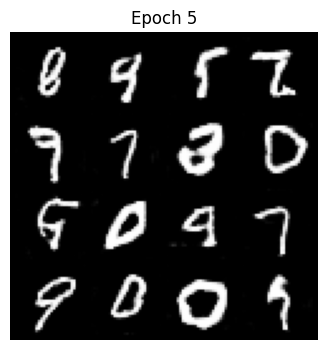

Epoch [6/10] Batch [0/469] D Loss: 0.5208 G Loss: 2.2136
Epoch [6/10] Batch [300/469] D Loss: 0.4608 G Loss: 1.6258


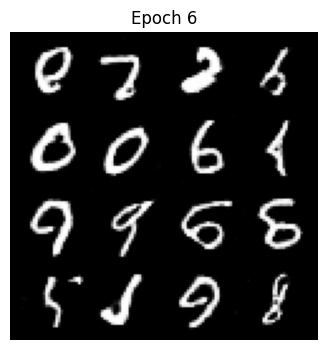

Epoch [7/10] Batch [0/469] D Loss: 0.5085 G Loss: 1.7601
Epoch [7/10] Batch [300/469] D Loss: 0.4580 G Loss: 2.1247


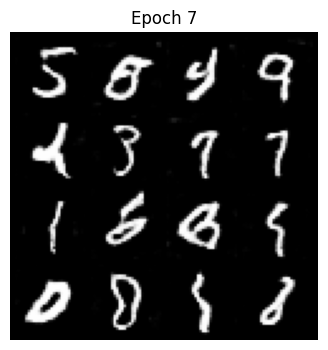

Epoch [8/10] Batch [0/469] D Loss: 1.3601 G Loss: 1.0984
Epoch [8/10] Batch [300/469] D Loss: 0.4307 G Loss: 2.7269


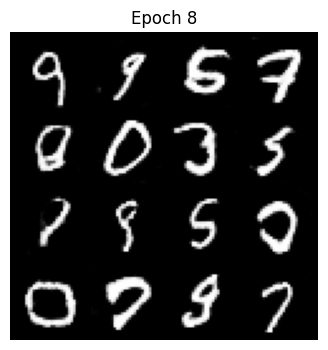

Epoch [9/10] Batch [0/469] D Loss: 0.5836 G Loss: 2.7348
Epoch [9/10] Batch [300/469] D Loss: 0.4625 G Loss: 1.8285


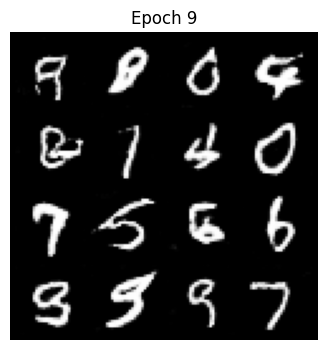

Epoch [10/10] Batch [0/469] D Loss: 0.6386 G Loss: 3.7169
Epoch [10/10] Batch [300/469] D Loss: 0.5343 G Loss: 2.0899


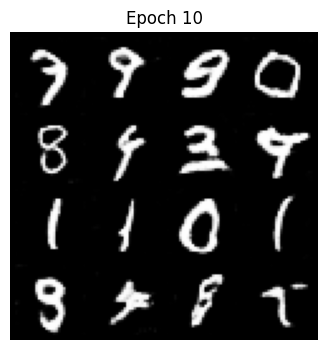

In [10]:
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = imgs.to(device)
        batch_size_curr = real_imgs.size(0)

        valid = torch.ones(batch_size_curr, 1, device=device)
        fake = torch.zeros(batch_size_curr, 1, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), valid)

        z = torch.randn(batch_size_curr, latent_dim, 1, 1, device=device)
        gen_imgs = generator(z)

        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        if i % 300 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}] "
                f"Batch [{i}/{len(dataloader)}] "
                f"D Loss: {d_loss.item():.4f} "
                f"G Loss: {g_loss.item():.4f}"
            )

    # ---- Visualization ----
    with torch.no_grad():
        z = torch.randn(16, latent_dim, 1, 1, device=device)
        samples = generator(z).cpu()

        grid = make_grid(samples, nrow=4, normalize=True)
        plt.figure(figsize=(4,4))
        plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {epoch+1}")
        plt.show()
